In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dask
import dask.dataframe as dd
import selfies as sf
import numpy as np

from dask import delayed
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import optim

/home/catj/miniforge3/envs/rxt-dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df = dd.read_csv("../data/processed/ligand_CHEMBL240_train_splityear=2015.csv", dtype={'smiles': str, 'pchembl_value': 'float32'})

In [3]:
# df = df.compute()

In [4]:
# df['selfies'] = [sf.encoder(smi) for smi in df['smiles']]

In [5]:
# vocab = sf.get_alphabet_from_selfies(df['selfies'])
# stoi = {x:i for i, x in enumerate(vocab, start=2)}
# stoi['[nop]'] = 0
# stoi['.'] = 1

In [6]:
# enc_selfies = [sf.selfies_to_encoding(selfies=selfies, vocab_stoi=stoi, pad_to_len=128, enc_type='label') for selfies in df['selfies']]

In [7]:
# enc_selfies = list(filter(lambda x: len(x) <= 128, enc_selfies))

In [8]:
# lengths = [np.count_nonzero(es) for es in enc_selfies]

In [9]:
# enc_selfies = torch.tensor(enc_selfies, dtype=torch.long)

In [10]:
class Embedding(pl.LightningModule):
    def __init__(self, embedding_dim, n_embeddings, padding_idx=None):
        super(Embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = n_embeddings
        self.padding_idx = padding_idx if padding_idx else None
        self.embedding = nn.Embedding(num_embeddings=self.num_embeddings,
                                      embedding_dim=self.embedding_dim,
                                      padding_idx=self.padding_idx)

    def forward(self, inp):
        inp = inp.type(torch.long)
        embedded = self.embedding(inp)

        return embedded

In [11]:
# emb = Embedding(128, 128, None)

In [12]:
# emb_selfies = emb(enc_selfies)

In [13]:
# emb_selfies.shape

In [14]:
class LSTMEncoder(pl.LightningModule):
    def __init__(self, input_dim, encoder_dim, num_layers, dropout):
        super(LSTMEncoder, self).__init__()
        
        self.input_size = input_dim
        self.n_directions = 1
        self.encoder_dim = encoder_dim
        self.n_layers = num_layers

        self.rnn = nn.LSTM(input_size=input_dim,
                           hidden_size=encoder_dim,
                           num_layers=num_layers,
                           dropout=dropout,
                           batch_first=True)
        
    def forward(self, inp, previous_hidden=None, pack=True):
        input_tensor = inp[0]#inp
        input_length = inp[1]#lengths
        batch_size = input_tensor.size(0)
        # TODO: warning: output shape is changed! (batch_first=True) Check hidden
        if pack:
            input_lengths_sorted, perm_idx = torch.sort(input_length, dim=0, descending=True)
            input_lengths_sorted = input_lengths_sorted.detach().to(device="cpu").tolist()
            input_tensor = torch.index_select(input_tensor, 0, perm_idx)
            rnn_input = pack_padded_sequence(input=input_tensor,
                                             lengths=input_lengths_sorted,
                                             batch_first=True)
        else:
            rnn_input = input_tensor
            
        if previous_hidden is None:
            previous_hidden = self.init_hidden(batch_size)
            cell = self.init_cell(batch_size)
            previous_hidden = (previous_hidden, cell)
        else:
            hidden = previous_hidden[0]
            cell = previous_hidden[1]
            hidden = torch.index_select(hidden, 1, perm_idx)
            cell = torch.index_select(cell, 1, perm_idx)
            previous_hidden = (hidden, cell)
        rnn_output, next_hidden = self.rnn(rnn_input)

        if pack:
            rnn_output, _ = pad_packed_sequence(rnn_output, batch_first=True)
            _, unperm_idx = perm_idx.sort(0)
            rnn_output = torch.index_select(rnn_output, 0, unperm_idx)
            hidden = next_hidden[0]
            cell = next_hidden[1]
            hidden = torch.index_select(hidden, 1, unperm_idx)
            cell = torch.index_select(cell, 1, unperm_idx)
            next_hidden = (hidden, cell)

        index_t = (input_length - 1).to(dtype=torch.long)
        index_t = index_t.view(-1, 1, 1).expand(-1, 1, rnn_output.size(2))

        embedded = torch.gather(rnn_output, dim=1, index=index_t).squeeze(1)

        return embedded, next_hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers * self.n_directions, batch_size, self.encoder_dim)

    def init_cell(self, batch_size):
        return torch.zeros(self.n_layers * self.n_directions, batch_size, self.encoder_dim)

In [15]:
# lstm = LSTMEncoder(128, 128, 2, 0.8)

In [16]:
# lengths = torch.tensor(lengths, dtype=torch.long)  # .reshape(-1, 1)

In [17]:
# rnn_out = lstm(emb_selfies, lengths)

In [18]:
class MLP(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.out_layer(x)
        return x

In [19]:
# mlp = MLP(128, 128, 1)

In [20]:
# mlp(rnn_out[0])

In [21]:
class PChEMBLValueRegressor(pl.LightningModule):
    def __init__(self, lr: float):
        super(PChEMBLValueRegressor, self).__init__()
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.embedding = Embedding(embedding_dim=128, n_embeddings=128)
        self.encoder = LSTMEncoder(input_dim=128, encoder_dim=128, num_layers=2, dropout=0.8)
        self.mlp = MLP(input_dim=128, hidden_dim=128, output_dim=1)

    def forward(self, inp):
        input_tensor = inp[0]
        input_length = inp[1]
        embedded = self.embedding(input_tensor)
        output, _ = self.encoder([embedded, input_length])
        output = self.mlp(output)
        return output

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.98)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = [batch['tokenized_smiles'], batch['length']], batch['labels']
        y_pred = self(x).squeeze()
        loss = self.criterion(y_pred, y)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = [batch['tokenized_smiles'], batch['length']], batch['labels']
        y_pred = self(x).squeeze()
        loss = self.criterion(y_pred, y)
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = [batch['tokenized_smiles'], batch['length']], batch['labels']
        y_pred = self(x).squeeze()
        return y_pred

In [22]:
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List


class SelfiesQsarDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        # if train:
        #     df = dd.read_csv("../data/processed/ligand_CHEMBL240_train_splityear=2015.csv", dtype={'smiles': str, 'pchembl_value': 'float32'}).compute()
        # else:
        #     df = dd.read_csv("../data/processed/ligand_CHEMBL240_test_splityear=2015.csv", dtype={'smiles': str, 'pchembl_value': 'float32'}).compute()
        if train:
            df = dd.read_csv("../data/processed/ligand_CHEMBL240_train_seed=42.csv", dtype={'smiles': str, 'pchembl_value': 'float32'}).compute()
        else:
            df = dd.read_csv("../data/processed/ligand_CHEMBL240_test_seed=42.csv", dtype={'smiles': str, 'pchembl_value': 'float32'}).compute()
            
        df['selfies'] = [sf.encoder(smi) for smi in df['smiles']]
        
        vocab = sf.get_alphabet_from_selfies(df['selfies'])
        stoi = {x:i for i, x in enumerate(vocab, start=2)}
        stoi['[nop]'] = 0
        stoi['.'] = 1
        
        enc = [sf.selfies_to_encoding(selfies=selfies, vocab_stoi=stoi, pad_to_len=128, enc_type='label') for selfies in df['selfies']]
        df['enc_selfies'] = enc
        df = df[df['enc_selfies'].apply(len) <= 128]
        
        self.inp = [sf.selfies_to_encoding(selfies=selfies, vocab_stoi=stoi, pad_to_len=128, enc_type='label') for selfies in df['selfies']]
        self.length = np.array([np.count_nonzero(enc_selfies) for enc_selfies in self.inp])
        self.target = df['pchembl_value'].values
        
        self.inp = torch.tensor(self.inp, dtype=torch.float32)
        self.length = torch.from_numpy(self.length)
        self.target = torch.from_numpy(self.target)

    def __len__(self):
        return len(self.inp)
    
    def __getitem__(self, index):
        sample = {}
        sample['tokenized_smiles'] = (self.inp[index])
        sample['length'] = (self.length[index])
        sample['labels'] = (self.target[index])
        return sample


class SelfiesQsarDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 128, max_selfies_len: int = 128):
        super().__init__()
        self.batch_size = batch_size
        self.max_selfies_len = max_selfies_len
        
    def setup(self, stage: Optional[str] = None):
        if stage in (None, 'fit'):
            self.qsar_train = SelfiesQsarDataset(train=True)
        if stage in (None, "test", "predict"):
            self.qsar_test = SelfiesQsarDataset(train=False)
    
    def train_dataloader(self):
        return DataLoader(self.qsar_train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          sampler=None)

    def test_dataloader(self):
        return DataLoader(self.qsar_test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          sampler=None)
    
    def predict_dataloader(self):
        return DataLoader(self.qsar_test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          sampler=None)

In [23]:
model = PChEMBLValueRegressor(lr=0.005)

In [24]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
selfies_dm = SelfiesQsarDataModule(batch_size=128)

In [26]:
trainer.fit(model, datamodule=selfies_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | criterion | MSELoss     | 0     
1 | embedding | Embedding   | 16.4 K
2 | encoder   | LSTMEncoder | 264 K 
3 | mlp       | MLP         | 16.6 K
------------------------------------------
297 K     Trainable params
0         Non-trainable params
297 K     Total params
1.189     Total estimated model params size (MB)


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.96it/s, loss=0.0896, v_num=11]


In [27]:
trainer.test(model, datamodule=selfies_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 89.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    3.3090929985046387     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.3090929985046387}]

In [29]:
preds = trainer.predict(model, datamodule=selfies_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, -256.18it/s]


In [30]:
preds = torch.cat(preds)

In [31]:
preds = preds.detach().to('cpu')

In [32]:
import seaborn as sns

<AxesSubplot:>

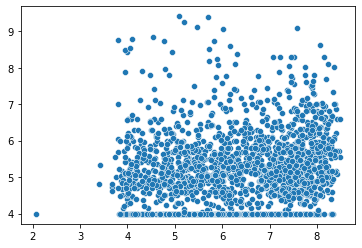

In [33]:
sns.scatterplot(x=preds, y=selfies_dm.qsar_test.target)

In [34]:
selfies_dm.qsar_test.target

tensor([5.1900, 5.0200, 3.9900,  ..., 4.6100, 4.9000, 6.8200])

In [35]:
from sklearn.metrics import r2_score, mean_squared_error

In [36]:
r2 = r2_score(y_true=selfies_dm.qsar_test.target, y_pred=preds)
r2

-2.466942746755932

In [37]:
rmse = mean_squared_error(y_true=selfies_dm.qsar_test.target, y_pred=preds, squared=False)
rmse

1.8190913